# Car Classification for stanford daset
* Identify the car brand, model, and year from car iamges using deep learning models

## Content
* Load Data and Environment Set Up
* Data Transformation
* Model Selection and Evaluation
* Model Application
* Conclusions

## Load Data and Environment Set Up

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp ./drive/MyDrive/Data/stanford_car_dataset.zip ./

In [7]:
%%time
# unzip dataset in colab
!mkdir ./stanford_car_dataset
!unzip -q stanford_car_dataset.zip -d ./stanford_car_dataset

mkdir: cannot create directory ‘./stanford_car_dataset’: File exists
CPU times: user 107 ms, sys: 36.2 ms, total: 143 ms
Wall time: 16.8 s


##  Data Tranformation

In [8]:
dataset_dir = "stanford_car_dataset/car_data/car_data/"

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # mean and std from imagenet dataset
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size=32, shuffle=False, num_workers=2)

## Model  Selection and Evaluation

### UDF Preparation

In [9]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            #inputs = inputs.to(device).half() # uncomment for half precision model
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward + backward + optimize
            # uncomment for half precision model 
            # with torch.cuda.amp.autocast():
            #     outputs = model(inputs)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / 32 * running_correct / len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            #images = images.to(device).half() # uncomment for half precision model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

### Model Training - Alexnet

In [10]:
NUM_CAR_CLASSES = 196
model_ft = models.alexnet(pretrained=True) 
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_CAR_CLASSES)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 84 s, loss: 5.2857, acc: 0.5882


  5%|▌         | 1/20 [02:37<50:00, 157.93s/it]

Accuracy of the network on the test images: 1 %
Epoch 2, duration: 77 s, loss: 5.2740, acc: 0.8456


 10%|█         | 2/20 [05:09<46:16, 154.26s/it]

Accuracy of the network on the test images: 0 %
Epoch 3, duration: 78 s, loss: 5.2648, acc: 0.8211


 15%|█▌        | 3/20 [07:45<43:58, 155.20s/it]

Accuracy of the network on the test images: 0 %
Epoch 4, duration: 83 s, loss: 5.2288, acc: 1.1642


 20%|██        | 4/20 [10:30<42:22, 158.92s/it]

Accuracy of the network on the test images: 1 %
Epoch 5, duration: 83 s, loss: 5.1141, acc: 2.1936


 25%|██▌       | 5/20 [13:09<39:46, 159.08s/it]

Accuracy of the network on the test images: 2 %
Epoch 6, duration: 79 s, loss: 4.8839, acc: 4.4118


 30%|███       | 6/20 [15:42<36:38, 157.01s/it]

Accuracy of the network on the test images: 4 %
Epoch 7, duration: 77 s, loss: 4.5714, acc: 6.5319


 35%|███▌      | 7/20 [18:16<33:44, 155.74s/it]

Accuracy of the network on the test images: 8 %
Epoch 8, duration: 79 s, loss: 4.2388, acc: 10.2574


 40%|████      | 8/20 [20:50<31:02, 155.20s/it]

Accuracy of the network on the test images: 8 %
Epoch 9, duration: 78 s, loss: 3.9722, acc: 12.7206


 45%|████▌     | 9/20 [23:22<28:18, 154.39s/it]

Accuracy of the network on the test images: 12 %
Epoch 10, duration: 78 s, loss: 3.6964, acc: 16.8015


 50%|█████     | 10/20 [25:54<25:36, 153.66s/it]

Accuracy of the network on the test images: 13 %
Epoch 11, duration: 78 s, loss: 3.4926, acc: 19.6814


 55%|█████▌    | 11/20 [28:27<22:59, 153.30s/it]

Accuracy of the network on the test images: 16 %
Epoch 12, duration: 77 s, loss: 3.2799, acc: 23.2843


 60%|██████    | 12/20 [30:59<20:22, 152.87s/it]

Accuracy of the network on the test images: 18 %
Epoch 13, duration: 78 s, loss: 3.1600, acc: 25.1103


 65%|██████▌   | 13/20 [33:30<17:47, 152.54s/it]

Accuracy of the network on the test images: 18 %
Epoch 14, duration: 78 s, loss: 3.0594, acc: 27.3775


 70%|███████   | 14/20 [36:03<15:15, 152.53s/it]

Accuracy of the network on the test images: 15 %
Epoch 15, duration: 81 s, loss: 2.9367, acc: 29.8284


 75%|███████▌  | 15/20 [38:38<12:46, 153.32s/it]

Accuracy of the network on the test images: 19 %
Epoch 16, duration: 77 s, loss: 1.8816, acc: 50.4167


 80%|████████  | 16/20 [41:09<10:10, 152.51s/it]

Accuracy of the network on the test images: 29 %
Epoch 17, duration: 80 s, loss: 1.3848, acc: 61.4338


 85%|████████▌ | 17/20 [43:46<07:41, 153.96s/it]

Accuracy of the network on the test images: 31 %
Epoch 18, duration: 79 s, loss: 1.1912, acc: 65.6863


 90%|█████████ | 18/20 [46:17<05:05, 152.98s/it]

Accuracy of the network on the test images: 32 %
Epoch 19, duration: 81 s, loss: 1.0281, acc: 69.9387


 95%|█████████▌| 19/20 [48:52<02:33, 153.79s/it]

Accuracy of the network on the test images: 32 %
Epoch 20, duration: 80 s, loss: 0.9257, acc: 72.9657


100%|██████████| 20/20 [51:29<00:00, 154.45s/it]

Accuracy of the network on the test images: 34 %
Finished Training


In [ ]:
# PATH = 'car_model.pth'
# torch.save(model_ft.state_dict(), PATH)

# model_loaded = torch.load(PATH)
# model_loaded

Text(0.5, 1.0, 'Test acc')

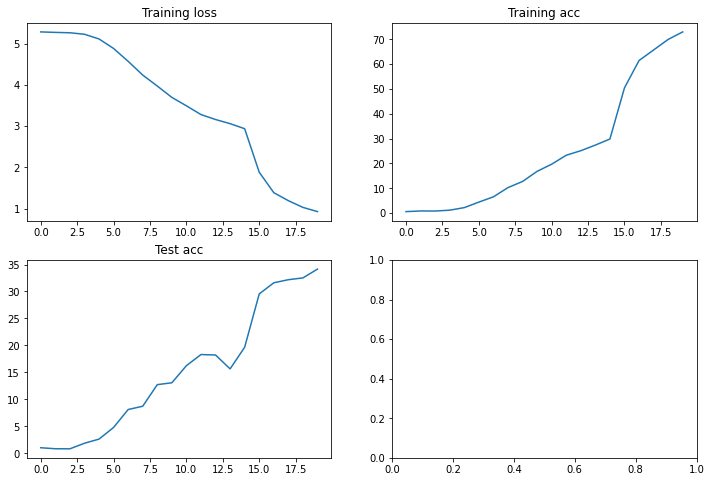

In [ ]:
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

### Model Training - Resnet

In [19]:
NUM_CAR_CLASSES = 196

model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_CAR_CLASSES)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

In [20]:
model_ft, training_losses, training_accs, test_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1, duration: 92 s, loss: 3.9226, acc: 15.3922


  5%|▌         | 1/20 [02:57<56:11, 177.45s/it]

Accuracy of the network on the test images: 31 %
Epoch 2, duration: 91 s, loss: 1.9815, acc: 46.3235


 10%|█         | 2/20 [05:54<53:10, 177.26s/it]

Accuracy of the network on the test images: 40 %
Epoch 3, duration: 95 s, loss: 1.2343, acc: 64.2770


 15%|█▌        | 3/20 [08:50<50:00, 176.53s/it]

Accuracy of the network on the test images: 61 %
Epoch 4, duration: 92 s, loss: 0.8740, acc: 74.0564


 20%|██        | 4/20 [11:40<46:25, 174.08s/it]

Accuracy of the network on the test images: 59 %
Epoch 5, duration: 90 s, loss: 0.6044, acc: 81.4216


 25%|██▌       | 5/20 [14:28<42:59, 172.00s/it]

Accuracy of the network on the test images: 66 %
Epoch 6, duration: 90 s, loss: 0.4603, acc: 85.7353


 30%|███       | 6/20 [17:16<39:48, 170.64s/it]

Accuracy of the network on the test images: 71 %
Epoch 7, duration: 89 s, loss: 0.3473, acc: 89.4730


 35%|███▌      | 7/20 [20:04<36:46, 169.73s/it]

Accuracy of the network on the test images: 72 %
Epoch 8, duration: 89 s, loss: 0.1462, acc: 95.9436


 40%|████      | 8/20 [22:52<33:48, 169.08s/it]

Accuracy of the network on the test images: 83 %
Epoch 9, duration: 89 s, loss: 0.0905, acc: 97.7941


 45%|████▌     | 9/20 [25:39<30:54, 168.60s/it]

Accuracy of the network on the test images: 84 %
Epoch 10, duration: 90 s, loss: 0.0738, acc: 98.2230


 50%|█████     | 10/20 [28:28<28:04, 168.43s/it]

Accuracy of the network on the test images: 84 %
Epoch 11, duration: 89 s, loss: 0.0688, acc: 98.3333


 55%|█████▌    | 11/20 [31:15<25:14, 168.24s/it]

Accuracy of the network on the test images: 84 %
Epoch 12, duration: 90 s, loss: 0.0572, acc: 98.8358


 60%|██████    | 12/20 [34:05<22:29, 168.68s/it]

Accuracy of the network on the test images: 85 %
Epoch 13, duration: 89 s, loss: 0.0559, acc: 98.6275


 65%|██████▌   | 13/20 [36:53<19:38, 168.36s/it]

Accuracy of the network on the test images: 85 %
Epoch 14, duration: 89 s, loss: 0.0542, acc: 98.7745


 70%|███████   | 14/20 [39:41<16:49, 168.31s/it]

Accuracy of the network on the test images: 85 %
Epoch 15, duration: 89 s, loss: 0.0543, acc: 98.8480


 75%|███████▌  | 15/20 [42:28<14:00, 168.04s/it]

Accuracy of the network on the test images: 85 %
Epoch 16, duration: 89 s, loss: 0.0578, acc: 98.6029


 80%|████████  | 16/20 [45:16<11:11, 167.89s/it]

Accuracy of the network on the test images: 85 %
Epoch 17, duration: 90 s, loss: 0.0539, acc: 98.8848


 85%|████████▌ | 17/20 [48:04<08:24, 168.07s/it]

Accuracy of the network on the test images: 85 %
Epoch 18, duration: 89 s, loss: 0.0570, acc: 98.6642


 90%|█████████ | 18/20 [50:52<05:35, 167.91s/it]

Accuracy of the network on the test images: 85 %
Epoch 19, duration: 89 s, loss: 0.0536, acc: 98.8235


 95%|█████████▌| 19/20 [53:39<02:47, 167.61s/it]

Accuracy of the network on the test images: 85 %
Epoch 20, duration: 90 s, loss: 0.0556, acc: 98.7255


100%|██████████| 20/20 [56:27<00:00, 169.35s/it]

Accuracy of the network on the test images: 85 %
Finished Training


Text(0.5, 1.0, 'Test acc')

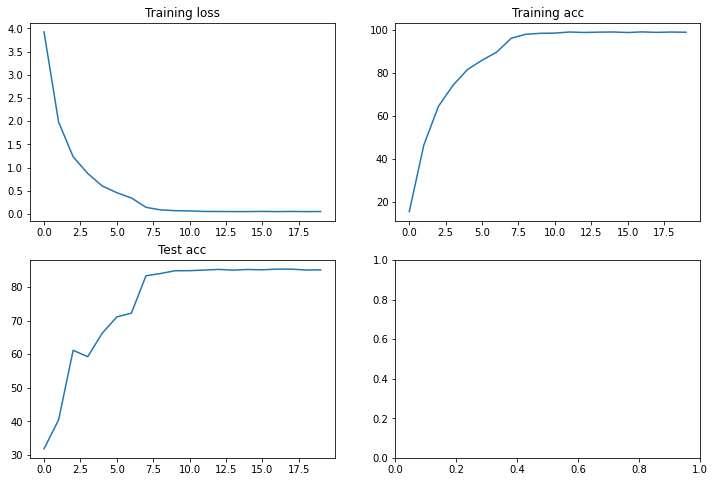

In [22]:
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)

axarr[1, 0].set_title("Test acc")

In [21]:
PATH = 'car_model_resnet.pth'
torch.save(model_ft.state_dict(), PATH)

## Model Application

In [23]:
model_ft.eval()

# transforms for the input image
loader = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
image = Image.open(dataset_dir+"test/Ford Mustang Convertible 2007/03653.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)

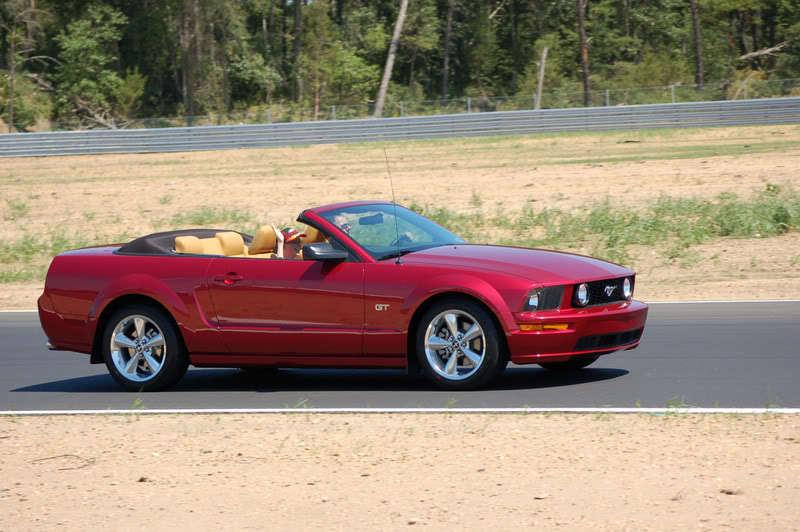

Ford Mustang Convertible 2007 confidence:  9.9095458984375


In [25]:
image = Image.open(dataset_dir+"test/Ford Mustang Convertible 2007/06569.jpg")
image = loader(image).float()
image = torch.autograd.Variable(image, requires_grad=True)
image = image.unsqueeze(0)
image = image.cuda()
output = model_ft(image)
conf, predicted = torch.max(output.data, 1)
display(Image.open(dataset_dir+"test/Ford Mustang Convertible 2007/06569.jpg"))
print(classes[predicted.item()], "confidence: ", conf.item())

## Conclusions:
* with limited data and computing resource, transfer learning is a practical way to get a good performance deep learning model
* The performance of Resnet model is much better than Alexnet. The accuary ub test data set reaches 80 after 10 epochs
* The model, year, and brand of the car can be idefntify by tarined model